In [1]:
from emlp.nn import MLP,EMLP,MLPH,EMLPH
import matplotlib.pyplot as plt
import seaborn as sns
import objax
from rpp.objax import MixedEMLP, MixedEMLPH
import jax.numpy as jnp
import numpy as np
from oil.datasetup.datasets import split_dataset

from torch.utils.data import DataLoader
import os
import sys
sys.path.append("../")
sys.path.append("../trainer/")
sys.path.append("../trainer/")
from hamiltonian_dynamics import WindyDoubleSpringPendulum, DoubleSpringPendulum, BHamiltonianFlow
from utils import LoaderTo
from datasets import ModifiedInertia
from jax import vmap
from emlp.reps import Scalar

import pandas as pd

In [2]:
bs = 500
ndata=5000
wind_level = 0.

split={'train':500,'val':.1,'test':.1}
dataset = WindyDoubleSpringPendulum
base_ds = dataset(n_systems=ndata,chunk_len=5, wind_scale=wind_level)
datasets = split_dataset(base_ds,splits=split)

dataloaders = {k:LoaderTo(DataLoader(v,batch_size=min(bs,len(v)),shuffle=(k=='train'),
                                     num_workers=0,pin_memory=False)) for k,v in datasets.items()}
trainloader = dataloaders['train'] 
testloader = dataloaders['val'] 


In [3]:
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

def scale_adjusted_rel_err(a,b,g):
    return  jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean())+jnp.abs(g-jnp.eye(g.shape[-1])).mean())

def equivariance_err(model,mb,group=None):
    x,y = mb
    group = model.G if group is None else group
    gs = group.samples(x.shape[0])
    rho_gin = vmap(model.rep_in.rho_dense)(gs)
    rho_gout = vmap(model.rep_out.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0])
    y2 = (rho_gout@model(x)[...,None])[...,0]
    return np.asarray(scale_adjusted_rel_err(y1,y2,gs))


def pendulum_equivariance_err(model,mb,group=None):
    (z0, ts), true_zs = mb
    group = model.G if group is None else group
    gs = group.samples(z0.shape[0])
    rho_gin = vmap(model.rep_in.rho_dense)(gs)
    rho_gout = vmap(model.rep_out.rho_dense)(gs)
    y1 = model((rho_gin@z0[...,None])[...,0])
    y2 = (rho_gout@model(z0)[...,None])[...,0]
    return np.asarray(scale_adjusted_rel_err(y1,y2,gs))


def mse(mdl, x, y):
    yhat = mdl(x)
    return ((yhat-y)**2).mean()

def pendulum_mse(mdl, minibatch):
    (z0, ts), true_zs = minibatch
    pred_zs = BHamiltonianFlow(mdl,z0,ts[0])
    return jnp.mean((pred_zs - true_zs)**2)

def namer(wind_level, trial, basic_wd, equiv_wd):
    return "./saved-outputs/pendulum" + str(wind_level) + "_basic" + str (basic_wd) +\
                "_equiv" + str(equiv_wd) + "/saved_model" + str(trial) + ".npz"

In [4]:
net_config={'num_layers':3,'ch':128,'group':base_ds.symmetry}
model = MixedEMLPH(base_ds.rep_in, Scalar, **net_config)

In [5]:
basic_wd = 0.01
equiv_wd = 1e-5
fname = namer(0.01, 0, basic_wd, equiv_wd)
objax.io.load_var_collection(fname,
                            model.vars())

In [12]:
basic_wd = 0.01
equiv_wd = 1e-5
wind_levels = [0.0001, 0.01, 0.05, 0.1, 0.5]
logger = []
ens_size = 10
for wnd in wind_levels:
    
    for trial in range(ens_size):
        fname = namer(wnd, trial, basic_wd, equiv_wd)
        if os.path.exists(fname):
            objax.io.load_var_collection(namer(wnd, trial, basic_wd, equiv_wd),
                                        model.vars())

#     for trial in range(10):
            test_mse = np.mean([pendulum_mse(model, mb) for mb in testloader]) 
            equiv_err = np.mean([pendulum_equivariance_err(model, mb) for mb in testloader]) 
            logger.append([wnd, trial, test_mse, equiv_err])

In [13]:
full_df = pd.DataFrame(logger)
full_df.columns = ["wind", 'trial', 'test_mse', 'equiv_err']

<AxesSubplot:xlabel='equiv_err', ylabel='Density'>

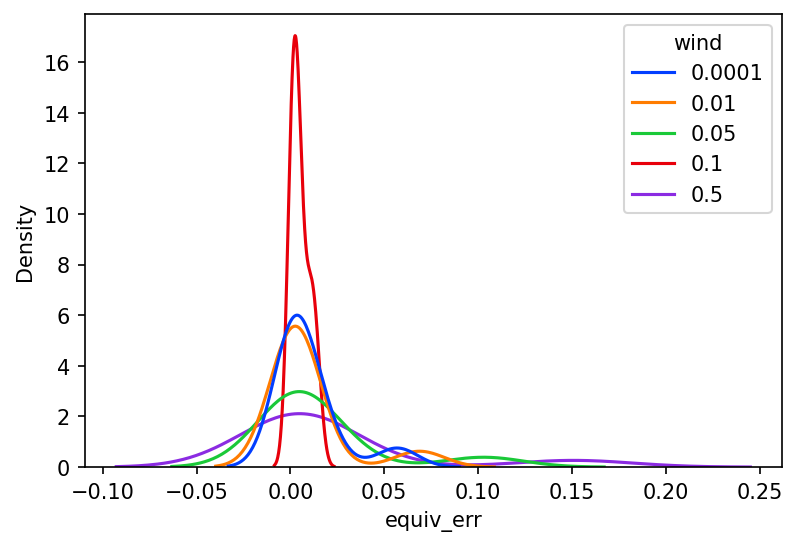

In [14]:
plt.figure(dpi=150)
sns.kdeplot(x='equiv_err', data=full_df, hue='wind', palette='bright')

<AxesSubplot:xlabel='wind', ylabel='equiv_err'>

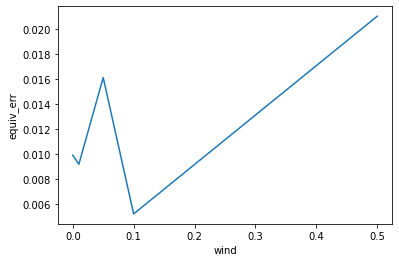

In [15]:
sns.lineplot(x='wind', y='equiv_err', data=full_df.groupby('wind').mean())

In [11]:
full_df.groupby('wind').mean()

,trial,test_mse,equiv_err
wind,,,
0.0001,4.5,0.075990,0.023976
0.0100,3.5,0.084886,0.006241
